Cluster Analysis for Pairs Trading

1. Data Preparation
2. k-Means Clustering
3. Hierarchical Clustering
4. Affinity Propagation Clustering
5. Model Performance
6. Pairs Extraction

# Import packages

In [360]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import matplotlib.cm as cm
import statsmodels.formula.api as sm
import statsmodels.tsa.stattools as ts
from sklearn.cluster import KMeans, DBSCAN 
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn import preprocessing
from statsmodels.tsa.stattools import coint 
from scipy import stats
import itertools
%matplotlib inline
import warnings 
warnings.filterwarnings('ignore')

# Data preprocessing

In [361]:
path = '/Users/cathyliu/Desktop/NYU MFE/7773 Machine Learning/Project 2/'
data = pd.read_csv(path+'all_stocks_5yr.csv')
data.head()

,date,open,high,low,close,volume,Name
0,2013-02-08,15.07,15.12,14.63,14.75,8407500,AAL
1,2013-02-11,14.89,15.01,14.26,14.46,8882000,AAL
2,2013-02-12,14.45,14.51,14.10,14.27,8126000,AAL
3,2013-02-13,14.30,14.94,14.25,14.66,10259500,AAL
4,2013-02-14,14.94,14.96,13.16,13.99,31879900,AAL


In [362]:
prices = data[['date','Name','close']]
# Convert 'date' column to datetime type
prices['date'] = pd.to_datetime(prices['date'])
# Set 'date' as the index
prices.set_index('date', inplace=True)
# Pivot the DataFrame
prices = prices.pivot(columns='Name', values='close')
prices.head()

Name,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACN,ADBE,ADI,...,XL,XLNX,XOM,XRAY,XRX,XYL,YUM,ZBH,ZION,ZTS
date,,,,,,,,,,,,,,,,,,,,,
2013-02-08,45.08,14.75,78.90,67.8542,36.25,46.89,34.41,73.31,39.12,45.70,...,28.24,37.51,88.61,42.87,31.84,27.09,65.30,75.85,24.14,33.05
2013-02-11,44.60,14.46,78.39,68.5614,35.85,46.76,34.26,73.07,38.64,46.08,...,28.31,37.46,88.28,42.84,31.96,27.46,64.55,75.65,24.21,33.26
2013-02-12,44.62,14.27,78.60,66.8428,35.42,46.96,34.30,73.37,38.89,46.27,...,28.41,37.58,88.46,42.87,31.84,27.95,64.75,75.44,24.49,33.74
2013-02-13,44.75,14.66,78.97,66.7156,35.27,46.64,34.46,73.56,38.81,46.26,...,28.42,37.80,88.67,43.08,32.00,28.26,64.41,76.00,24.74,33.55
2013-02-14,44.58,13.99,78.84,66.6556,36.57,46.77,34.70,73.13,38.61,46.54,...,28.22,38.44,88.52,42.91,32.12,28.47,63.89,76.34,24.63,33.27


In [363]:
data = prices

In [364]:
data.describe().T.head(10)

,count,mean,std,min,25%,50%,75%,max
Name,,,,,,,,
A,1259.0,49.202025,9.229804,33.3700,41.56000,46.70,56.495,74.82
AAL,1259.0,38.393252,10.957636,13.0200,34.33000,40.87,46.535,58.47
AAP,1259.0,132.433463,31.274463,76.1800,104.44000,141.30,156.730,200.38
AAPL,1259.0,109.066698,30.556812,55.7899,84.83065,109.01,127.120,179.26
ABBV,1259.0,60.864440,13.730380,35.2700,52.65000,60.17,65.745,123.21
ABC,1259.0,82.092979,16.315690,46.1800,70.52500,82.56,92.520,115.48
ABT,1259.0,42.940326,5.860169,32.9300,38.47500,42.30,45.785,63.42
ACN,1259.0,101.119079,22.129031,70.2800,80.67000,97.77,117.045,162.55
ADBE,1259.0,90.458156,36.997773,38.1100,65.86500,80.59,105.710,201.30


# 1. Data Preparation

## Check if there are null data

In [365]:
data.isnull().values.any()

True

In [366]:
print('Data Shape before cleaning =', data.shape)

missing_percentage = data.isnull().mean().sort_values(ascending=False)
missing_percentage.head(10)
# drop the stock which has too much missing data!
dropped_list = sorted(list(missing_percentage[missing_percentage > 0.03].index))
data.drop(labels=dropped_list, axis=1, inplace=True)

print('Data Shape after cleaning =', data.shape)

Data Shape before cleaning = (1259, 505)
Data Shape after cleaning = (1259, 476)


In [367]:
data = data.fillna(method='ffill')
data.isnull().values.any()
prices = data

In [368]:
data.isnull().values.any()

False

In [369]:
backtest = data.loc['2017-02-08':'2018-02-07']

In [260]:
#Calculate log returns and create a data frame
returns = data.pct_change()
returns = np.log(1 + returns)
returns = returns.iloc[1:]
returns.head()

Name,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACN,ADBE,ADI,...,XL,XLNX,XOM,XRAY,XRX,XYL,YUM,ZBH,ZION,ZTS
date,,,,,,,,,,,,,,,,,,,,,
2013-02-11,-0.010705,-0.019857,-0.006485,0.010368,-0.011096,-0.002776,-0.004369,-0.003279,-0.012346,0.008281,...,0.002476,-0.001334,-0.003731,-0.000700,0.003762,0.013566,-0.011552,-0.002640,0.002896,0.006334
2013-02-12,0.000448,-0.013227,0.002675,-0.025386,-0.012067,0.004268,0.001167,0.004097,0.006449,0.004115,...,0.003526,0.003198,0.002037,0.000700,-0.003762,0.017687,0.003094,-0.002780,0.011499,0.014329
2013-02-13,0.002909,0.026963,0.004696,-0.001905,-0.004244,-0.006838,0.004654,0.002586,-0.002059,-0.000216,...,0.000352,0.005837,0.002371,0.004887,0.005013,0.011030,-0.005265,0.007396,0.010156,-0.005647
2013-02-14,-0.003806,-0.046780,-0.001648,-0.000900,0.036195,0.002783,0.006940,-0.005863,-0.005167,0.006035,...,-0.007062,0.016789,-0.001693,-0.003954,0.003743,0.007404,-0.008106,0.004464,-0.004456,-0.008381
2013-02-15,-0.053681,0.035806,0.002027,-0.013876,0.027244,-0.003641,0.010891,0.013986,0.000647,-0.007874,...,0.015820,-0.008360,-0.001809,-0.002567,-0.007500,-0.006696,0.001564,-0.005780,-0.011844,0.021116


## Standard scaling

In [261]:
from sklearn.preprocessing import StandardScaler

#Prepare the scaler
scale = StandardScaler().fit(returns)

#Fit the scaler
scaled_data = pd.DataFrame(scale.fit_transform(data),columns = data.columns, index = data.index)
scaled_data.head()

Name,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACN,ADBE,ADI,...,XL,XLNX,XOM,XRAY,XRX,XYL,YUM,ZBH,ZION,ZTS
date,,,,,,,,,,,,,,,,,,,,,
2013-02-08,-0.446777,-2.158554,-1.712411,-1.349253,-1.793411,-2.158472,-1.456224,-1.257178,-1.388153,-1.138554,...,-1.826702,-1.295297,0.135345,-1.441749,-1.088154,-1.267686,-1.356718,-1.977593,-1.047121,-1.006013
2013-02-11,-0.498803,-2.185030,-1.728725,-1.326100,-1.822556,-2.166443,-1.481830,-1.268028,-1.401132,-1.110150,...,-1.808629,-1.300552,0.087908,-1.445698,-1.073053,-1.234987,-1.456959,-1.990885,-1.037995,-0.988479
2013-02-12,-0.496635,-2.202376,-1.722007,-1.382365,-1.853885,-2.154180,-1.475002,-1.254466,-1.394372,-1.095948,...,-1.782810,-1.287939,0.113783,-1.441749,-1.088154,-1.191682,-1.430228,-2.004842,-1.001491,-0.948401
2013-02-13,-0.482545,-2.166771,-1.710172,-1.386530,-1.864814,-2.173801,-1.447688,-1.245876,-1.396535,-1.096695,...,-1.780228,-1.264815,0.143969,-1.414103,-1.068019,-1.164285,-1.475670,-1.967624,-0.968898,-0.964265
2013-02-14,-0.500971,-2.227939,-1.714330,-1.388494,-1.770096,-2.165830,-1.406717,-1.265315,-1.401943,-1.075766,...,-1.831866,-1.197546,0.122407,-1.436483,-1.052918,-1.145726,-1.545170,-1.945028,-0.983239,-0.987644


# Split the training data

In [263]:
scaled_data.index

DatetimeIndex(['2013-02-08', '2013-02-11', '2013-02-12', '2013-02-13',
               '2013-02-14', '2013-02-15', '2013-02-19', '2013-02-20',
               '2013-02-21', '2013-02-22',
               ...
               '2018-01-25', '2018-01-26', '2018-01-29', '2018-01-30',
               '2018-01-31', '2018-02-01', '2018-02-02', '2018-02-05',
               '2018-02-06', '2018-02-07'],
              dtype='datetime64[ns]', name='date', length=1259, freq=None)

In [264]:
import pandas as pd

# extract first 4 years data
training_set = scaled_data.loc['2013-02-08':'2017-02-08']
training_set = pd.DataFrame(training_set)
training_set.tail()

Name,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACN,ADBE,ADI,...,XL,XLNX,XOM,XRAY,XRX,XYL,YUM,ZBH,ZION,ZTS
date,,,,,,,,,,,,,,,,,,,,,
2017-02-02,-0.032736,0.512791,0.956641,0.637208,0.001862,0.365255,-0.032491,0.566039,0.613844,1.068750,...,0.935904,0.873083,-0.606385,0.355191,-1.485823,0.650976,-1.307267,0.798427,1.251339,0.885170
2017-02-03,0.019290,0.530138,0.969756,0.655214,-0.014167,0.440673,-0.027369,0.604465,0.668193,1.090426,...,0.861030,0.881492,-0.593448,0.436810,-1.495891,0.690745,-1.232421,0.832986,1.452112,0.903539
2017-02-06,0.007368,0.630564,0.890426,0.694828,-0.015624,0.483593,-0.087118,0.590451,0.648995,1.091174,...,0.930740,0.882543,-0.626510,0.452607,-1.536161,0.507805,-1.223065,0.773172,1.407785,0.891014
2017-02-07,0.047471,0.618696,0.855560,0.735424,-0.022182,0.505053,-0.008591,0.669112,0.662515,1.149477,...,0.935904,0.867828,-0.704133,0.474987,-1.536161,0.511340,-1.197671,0.830992,1.388229,0.908549
2017-02-08,0.078904,0.608653,0.969116,0.752121,-0.025096,0.550427,-0.092240,0.646960,0.694151,1.236932,...,0.992705,0.882543,-0.889565,0.460506,-1.390181,0.491897,-1.184305,0.767191,1.303488,0.906879


# 2. Calculate average return and volatility
this is the source data we use to conduct the clustering

In [265]:
#Calculate returns and create a data frame
data = data.loc['2013-02-08':'2017-02-08']
average_return = data.pct_change().mean()*266
average_return = pd.DataFrame(average_return)
average_return.columns = ['returns']

#Calculate the volatility
average_return['volatility'] = data.pct_change().std()*np.sqrt(266)

In [266]:
from sklearn.preprocessing import StandardScaler

#Prepare the scaler
scale = StandardScaler().fit(average_return)
#Fit the scaler
scaled_data = pd.DataFrame(scale.fit_transform(average_return),columns = average_return.columns, index = average_return.index)
X = scaled_data
X.head()

,returns,volatility
Name,,
A,-0.721523,0.165739
AAL,1.938705,1.602023
AAP,0.716822,0.262070
AAPL,0.523266,-0.091438
ABBV,0.245697,0.331859


# 3. Clustering
K-Means
层次聚类
DBSCAN——Density-Based Spatial Clustering of Applications with Noise
Gaussian Mixture Model，GMM

In [267]:
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture

The Elbow Method is a technique used to find the optimal number of clusters (K) in a dataset for K-Means clustering. The basic idea is to run K-Means with different values of K and plot the within-cluster sum of squares (inertia) against the number of clusters. The "elbow" in the plot represents the point where adding more clusters does not significantly reduce the inertia, and it's considered a good choice for the number of clusters.

Here's how you can implement the Elbow Method with K-Means in Python:

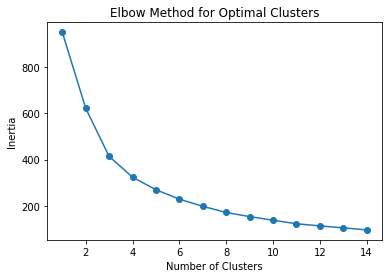

In [268]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

df = X
# 假设df是你的DataFrame
data = df[['returns', 'volatility']]

# 使用标准化处理数据
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)

# 尝试不同的聚类数量
inertia_values = []
for k in range(1, 15):
    kmeans = KMeans(n_clusters=k, random_state=100)
    kmeans.fit(scaled_data)
    inertia_values.append(kmeans.inertia_)

# 画出肘部法图像
plt.plot(range(1, 15), inertia_values, marker='o')
plt.title('Elbow Method for Optimal Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

By observing the chart we can conclude that the optimal number of clusters would be somewhere between 5 and 6. If you look at the iterations after 6, you can see that we start obtaining less informative clusters.

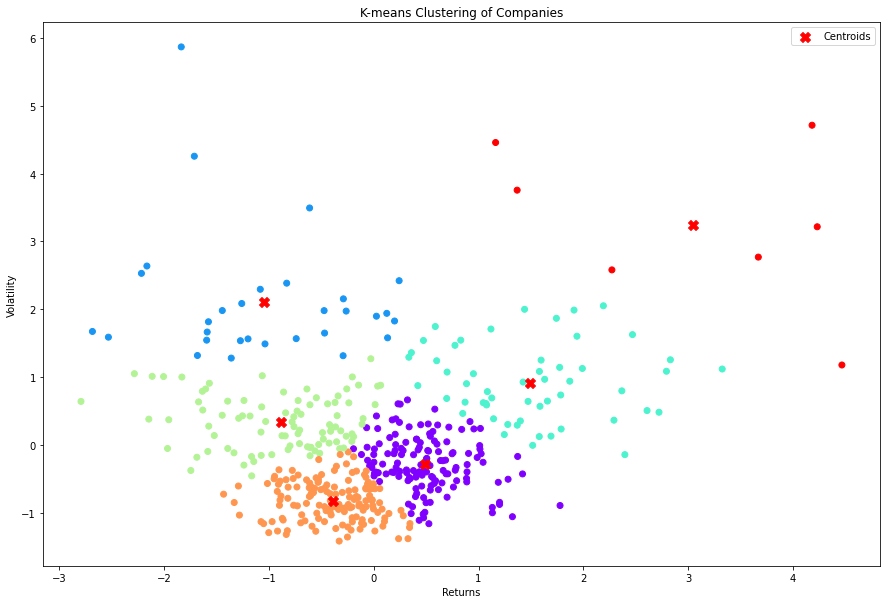

In [269]:
# optimal_clusters
optimal_clusters = 6
# use optimal_clusters for clustering
kmeans = KMeans(n_clusters=optimal_clusters, random_state=82)
df['cluster'] = kmeans.fit_predict(scaled_data)
# plot
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
plt.scatter(df['returns'], df['volatility'], c=df['cluster'], cmap='rainbow')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=100, c='red', marker='X', label='Centroids')
plt.title('K-means Clustering of Companies')
plt.xlabel('Returns')
plt.ylabel('Volatility')
plt.legend()
plt.colorbar(scatter)
plt.show()

# Hierarchical Clustering

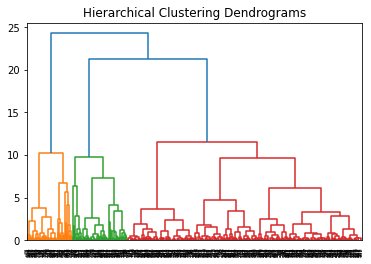

In [429]:
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as shc
# Assuming X is your data
plt.title("Hierarchical Clustering Dendrograms")  
# As we want to minimize the variance distance between our clusters we shall go with Ward’s linkage.
dend = shc.dendrogram(shc.linkage(X, method='ward'))
plt.xticks(rotation=90)  
plt.show()

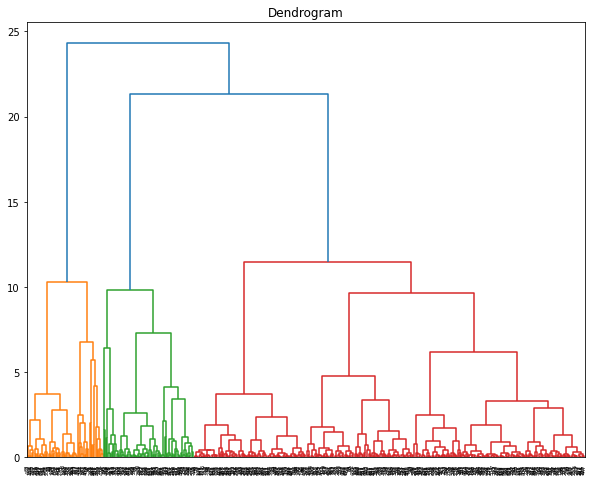

In [430]:
plt.figure(figsize=(10, 8))  
plt.title("Dendrogram")  
dend = shc.dendrogram(shc.linkage(X, method='ward'))
plt.axhline(y=49, color='purple', linestyle='--')
plt.axhline(y=28, color='purple', linestyle='--')

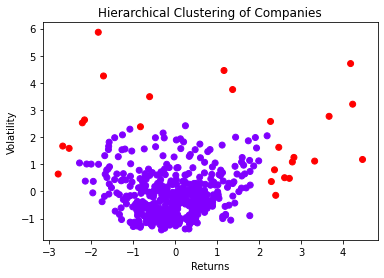

In [434]:
# Import necessary libraries
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
# Assuming 'optimal_clusters' is the desired number of clusters
optimal_clusters = 2

# Using AgglomerativeClustering for hierarchical clustering
agg_clustering = AgglomerativeClustering(n_clusters=optimal_clusters)
hier = agg_clustering.fit_predict(scaled_data)

# Plotting the hierarchical clustering result
plt.scatter(X.iloc[:,0], X.iloc[:,1], c=hier, cmap='rainbow')
plt.title('Hierarchical Clustering of Companies')
plt.xlabel('Returns')
plt.ylabel('Volatility')
plt.show()

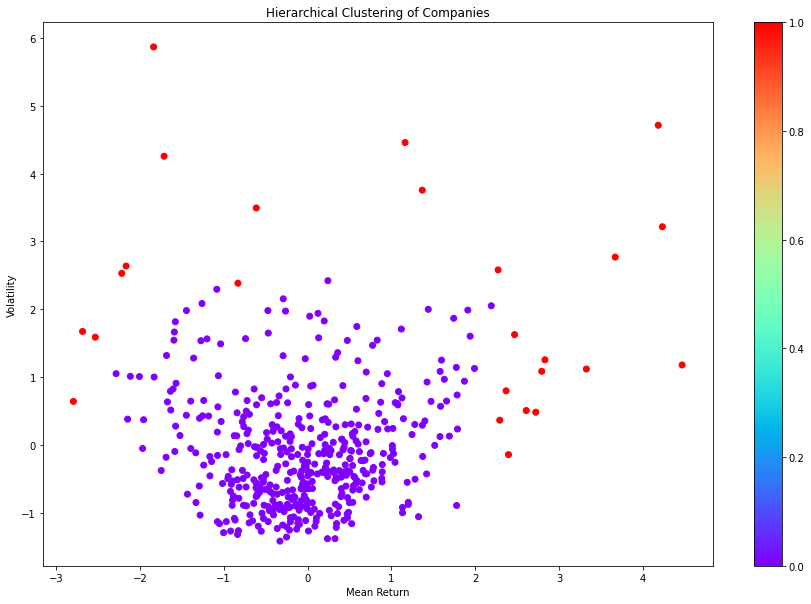

In [436]:
#Fit the model
optimal_clusters = 2
agg_clustering = AgglomerativeClustering(n_clusters=optimal_clusters)
hier = agg_clustering.fit_predict(scaled_data)
#Plot the results
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
scatter = ax.scatter(X.iloc[:,0], X.iloc[:,1], c=hier, cmap='rainbow')
ax.set_title('Hierarchical Clustering of Companies')
ax.set_xlabel('Mean Return')
ax.set_ylabel('Volatility')
plt.colorbar(scatter)
plt.show()

# DBSCAN

In [328]:
from sklearn.metrics import silhouette_score
import numpy as np

eps_values = [0.1,0.5, 1.0, 1.5,2,2.5,3]
min_samples_values = [3, 5, 10, 15,20,25,30,35,40]

best_score = -1
best_params = {}
epss = []
min_samples = []
Silhouettes = []
for eps_val in eps_values:
    for min_samples_val in min_samples_values:
        epss.append(eps_val)
        min_samples.append(min_samples_val)
        dbscan = DBSCAN(eps=eps_val, min_samples=min_samples_val)
        df['cluster'] = dbscan.fit_predict(scaled_data)

        # Check if there is only one label in the clustering result
        unique_labels = np.unique(df['cluster'])
        if len(unique_labels) == 1:
            print(f"Issue with parameters: eps={eps_val}, min_samples={min_samples_val}. Only one label found.")
            Silhouettes.append(0)
            continue

        score = silhouette_score(scaled_data, df['cluster'])
        Silhouettes.append(score)
        print(f"Parameters: eps={eps_val}, min_samples={min_samples_val}, Silhouette Score: {score}")

        if score > best_score:
            best_score = score
            best_params['eps'] = eps_val
            best_params['min_samples'] = min_samples_val

print(f"Best Parameters: {best_params}")


Parameters: eps=0.1, min_samples=3, Silhouette Score: -0.19803814887550575
Parameters: eps=0.1, min_samples=5, Silhouette Score: -0.31663677177891264
Parameters: eps=0.1, min_samples=10, Silhouette Score: -0.3879952043138964
Issue with parameters: eps=0.1, min_samples=15. Only one label found.
Issue with parameters: eps=0.1, min_samples=20. Only one label found.
Issue with parameters: eps=0.1, min_samples=25. Only one label found.
Issue with parameters: eps=0.1, min_samples=30. Only one label found.
Issue with parameters: eps=0.1, min_samples=35. Only one label found.
Issue with parameters: eps=0.1, min_samples=40. Only one label found.
Parameters: eps=0.5, min_samples=3, Silhouette Score: 0.6977148313431716
Parameters: eps=0.5, min_samples=5, Silhouette Score: 0.7440903962718779
Parameters: eps=0.5, min_samples=10, Silhouette Score: 0.623347147734726
Parameters: eps=0.5, min_samples=15, Silhouette Score: 0.5727107225504758
Parameters: eps=0.5, min_samples=20, Silhouette Score: 0.53574

In [329]:
print(len(epss))
print(len(min_samples))
print(len(Silhouettes))

63
63
63


0.5 5


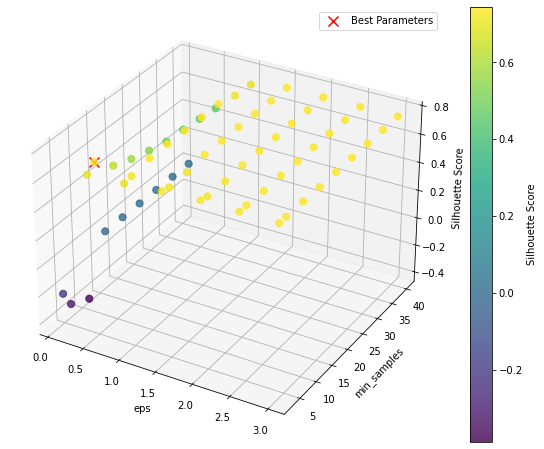

In [330]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import DBSCAN

# your previous code here ...

# 假设best_params包含了最佳的eps和min_samples参数
best_eps = best_params['eps']
best_min_samples = best_params['min_samples']
print(best_eps,best_min_samples)

# 创建一个3D子图
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# 设置坐标轴标签
ax.set_xlabel('eps')
ax.set_ylabel('min_samples')
ax.set_zlabel('Silhouette Score')

# 绘制3D散点图，增加点的大小和颜色深度
sc = ax.scatter3D(epss, min_samples, Silhouettes, c=Silhouettes, cmap='viridis', s=50, alpha=0.8)

# 在最佳参数位置添加标记
ax.scatter3D(best_eps, best_min_samples, best_score, c='red', marker='x', s=100, label='Best Parameters')

# 显示图例
ax.legend()

# 显示颜色条
fig.colorbar(sc, ax=ax, orientation='vertical', label='Silhouette Score')

# 显示图表
plt.show()

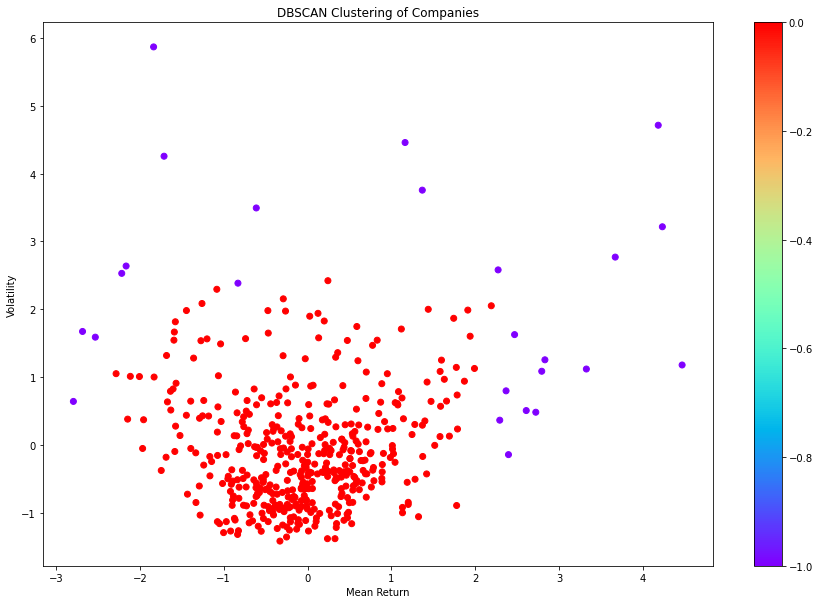

In [340]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt

# Using DBSCAN for clustering
dbscan = DBSCAN(eps=0.5, min_samples=5)  # You may need to adjust 'eps' and 'min_samples' based on your data
df['cluster'] = dbscan.fit_predict(scaled_data)
dbscan_labels = dbscan.fit_predict(scaled_data)
#Plot the results
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
scatter = ax.scatter(X.iloc[:,0], X.iloc[:,1], c=df['cluster'], cmap='rainbow')
ax.set_title('DBSCAN Clustering of Companies')
ax.set_xlabel('Mean Return')
ax.set_ylabel('Volatility')
plt.colorbar(scatter)
plt.show()


# Affinity Propagation Clustering

In [440]:
X = X[['returns','volatility']]

best preference: -20
best_damping: 0.8


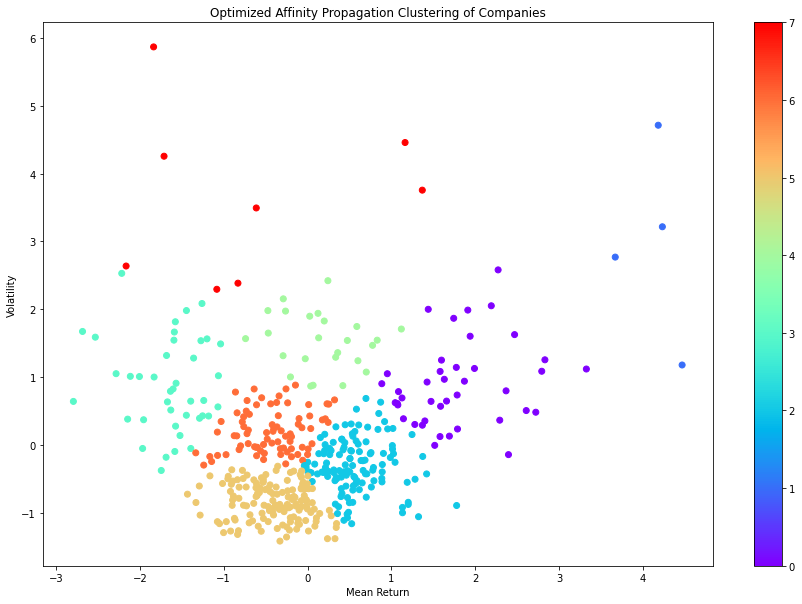

In [444]:
from sklearn.cluster import AffinityPropagation
from sklearn.metrics import silhouette_score
preference_values = [-40, -30, -20, -10]
damping_values = [0.6, 0.7, 0.8, 0.9]
best_silhouette_score = -1
best_preference = None
best_damping = None
# grid search for best paras
for preference in preference_values:
    for damping in damping_values:
        ap = AffinityPropagation(preference=preference, damping=damping)
        labels = ap.fit_predict(X)
        silhouette_avg = silhouette_score(X, labels)
        
        if silhouette_avg > best_silhouette_score:
            best_silhouette_score = silhouette_avg
            best_preference = preference
            best_damping = damping
# use the best paras
best_ap = AffinityPropagation(preference=best_preference, damping=best_damping)
best_labels = best_ap.fit_predict(X)
print('best preference:',best_preference)
print('best_damping:',best_damping)
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
scatter = ax.scatter(X.iloc[:,0], X.iloc[:,1], c=best_labels, cmap='rainbow')
ax.set_title('Optimized Affinity Propagation Clustering of Companies')
ax.set_xlabel('Mean Return')
ax.set_ylabel('Volatility')
plt.colorbar(scatter)
plt.show()

The number of clusters is: 12


<Figure size 432x288 with 0 Axes>

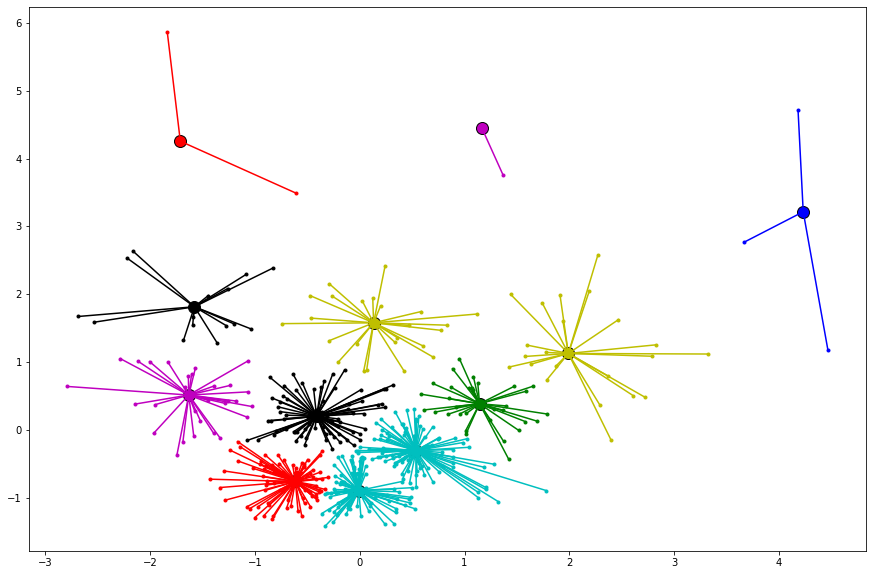

In [445]:
from itertools import cycle

#Extract the cluster centers and labels
cci = ap.cluster_centers_indices_
labels2 = ap.labels_

#Print their number
clusters = len(cci)
print('The number of clusters is:',clusters)

#Plot the results
X_ap = np.asarray(X)
plt.close('all')
plt.figure(1)
plt.clf
fig=plt.figure(figsize=(15,10))
colors = cycle('cmykrgbcmykrgbcmykrgbcmykrgb')
for k, col in zip(range(clusters),colors):
    cluster_members = labels2 == k
    cluster_center = X_ap[cci[k]]
    plt.plot(X_ap[cluster_members, 0], X_ap[cluster_members, 1], col + '.')
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col, markeredgecolor='k', markersize=12)
    for x in X_ap[cluster_members]:
        plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], col)

plt.show()

# Evaluate and compare clustering models?

In [446]:
from sklearn import metrics
from sklearn.metrics import silhouette_score
print("k-Means Clustering", metrics.silhouette_score(X, kmeans.fit_predict(X), metric='euclidean'))
print("Hierarchical Clustering", metrics.silhouette_score(X, hc.fit_predict(X), metric='euclidean'))
print("DBSCAN Clustering", metrics.silhouette_score(X, dbscan.fit_predict(X), metric='euclidean'))
print("Affinity Propagation Clustering", metrics.silhouette_score(X, ap.labels_, metric='euclidean'))

k-Means Clustering 0.3625840973611464
Hierarchical Clustering 0.478869014204343
DBSCAN Clustering 0.5883442406669541
Affinity Propagation Clustering 0.3390764199688775


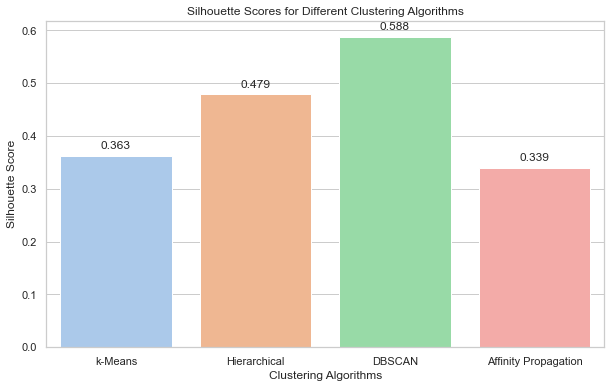

In [451]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

# 使用四个不同的聚类算法计算轮廓系数
kmeans_silhouette = metrics.silhouette_score(X, kmeans.fit_predict(X), metric='euclidean')
hc_silhouette = metrics.silhouette_score(X, hc.fit_predict(X), metric='euclidean')
dbscan_silhouette = metrics.silhouette_score(X, dbscan.fit_predict(X), metric='euclidean')
ap_silhouette = metrics.silhouette_score(X, ap.labels_, metric='euclidean')

# 将轮廓系数值存储在列表中
silhouette_scores = [kmeans_silhouette, hc_silhouette, dbscan_silhouette, ap_silhouette]
clustering_algorithms = ['k-Means', 'Hierarchical', 'DBSCAN', 'Affinity Propagation']

# 设置Seaborn样式和颜色
sns.set(style="whitegrid")
colors = sns.color_palette("pastel")

# 绘制柱形图
plt.figure(figsize=(10, 6))
barplot = sns.barplot(x=clustering_algorithms, y=silhouette_scores, palette=colors)
plt.title('Silhouette Scores for Different Clustering Algorithms')
plt.xlabel('Clustering Algorithms')
plt.ylabel('Silhouette Score')

# 添加数据标签
for p in barplot.patches:
    barplot.annotate(f"{p.get_height():.3f}", (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.show()

### So, we choose: DBSCAN.

# Extract the trading pairs

In [416]:
clustered_series = pd.Series(index=X.index, data=dbscan_labels.flatten())
clustered_series_all = pd.Series(index=X.index, data=dbscan_labels.flatten())
clustered_series = clustered_series[clustered_series != -1]
'''
plt.figure(figsize=(12,8))
plt.barh(range(len(clustered_series.value_counts())),clustered_series.value_counts())
plt.title('Clusters')
plt.xlabel('Stocks per Cluster')
plt.ylabel('Cluster Number')
plt.show()
'''

"\nplt.figure(figsize=(12,8))\nplt.barh(range(len(clustered_series.value_counts())),clustered_series.value_counts())\nplt.title('Clusters')\nplt.xlabel('Stocks per Cluster')\nplt.ylabel('Cluster Number')\nplt.show()\n"

In [411]:
cluster_size_limit = 10000000
counts = clustered_series.value_counts()
ticker_count = counts[(counts>1) & (counts<=cluster_size_limit)]
print ("Number of clusters: %d" % len(ticker_count))
print ("Number of Pairs: %d" % (ticker_count*(ticker_count-1)).sum())

Number of clusters: 1
Number of Pairs: 202950


In [412]:
def find_coint_pairs(data, significance=0.05):
    n = data.shape[1]    
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(1):
        for j in range(i+1, n):
            S1 = data[keys[i]]            
            S2 = data[keys[j]]
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < significance:
                pairs.append((keys[i], keys[j]))
    return score_matrix, pvalue_matrix, pairs

In [413]:
from statsmodels.tsa.stattools import coint

cluster_dict = {}

for i, clust in enumerate(ticker_count.index):
    tickers = clustered_series[clustered_series == clust].index
    score_matrix, pvalue_matrix, pairs = find_coint_pairs(prices[tickers])
    cluster_dict[clust] = {}
    cluster_dict[clust]['score_matrix'] = score_matrix
    cluster_dict[clust]['pvalue_matrix'] = pvalue_matrix
    cluster_dict[clust]['pairs'] = pairs
    
pairs = []   
for cluster in cluster_dict.keys():
    pairs.extend(cluster_dict[cluster]['pairs'])
    
print ("Number of pairs:", len(pairs))
print ("In those pairs, we found %d unique tickers." % len(np.unique(pairs)))
print(pairs)

Number of pairs: 4
In those pairs, we found 5 unique tickers.
[('A', 'DOV'), ('A', 'EMN'), ('A', 'ETN'), ('A', 'SNI')]


In [358]:
for (i,j) in pairs:
    print(i,j)

A DOV
A EMN
A ETN
A SNI


# backtest our strategy

In [373]:
pair_price = backtest[[i,j]]
pair_price.head()

Name,A,SNI
date,,
2017-02-08,49.93,75.19
2017-02-09,50.47,77.23
2017-02-10,50.36,77.83
2017-02-13,50.52,77.47
2017-02-14,50.39,76.90


In [472]:
def backtestor(df,i,j):
    # Calculate the spread between the two stocks
    first = i
    second = j
    df['Spread'] = df[first] - df[second]

    # Define entry and exit points based on the spread
    entry_threshold = 1.0  # Adjust as needed
    exit_threshold = 0.5   # Adjust as needed

    df['Long_Entry'] = np.where(df['Spread'] < -entry_threshold, 1, 0)
    df['Short_Entry'] = np.where(df['Spread'] > entry_threshold, 1, 0)
    df['Exit'] = np.where(np.abs(df['Spread']) < exit_threshold, 1, 0)

    # Calculate daily returns
    df['Return_'+first] = df[first].pct_change()
    df['Return_'+second] = df[second].pct_change()

    # Calculate strategy returns
    df['Strategy_Return'] = df['Long_Entry'].shift(1) * df['Return_'+first] - df['Short_Entry'].shift(1) * df['Return_'+second]

    # Calculate cumulative returns
    df['Cumulative_Return'] = (1 + df['Strategy_Return']).cumprod()

    # Calculate drawdown
    df['Previous_Peak'] = df['Cumulative_Return'].cummax()
    df['Drawdown'] = (df['Cumulative_Return'] / df['Previous_Peak']) - 1

    # Calculate Sharpe ratio (assuming risk-free rate is 0 for simplicity)
    sharpe_ratio = df['Strategy_Return'].mean() / df['Strategy_Return'].std()

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(df.index, df[first], label='Stock '+first)
    plt.plot(df.index, df[second], label='Stock '+second)
    plt.title('Stock Prices Over Time')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.plot(df.index, df['Spread'], label='Spread '+first+'-'+second)
    '''
    plt.axhline(y=entry_threshold, color='r', linestyle='--', label='Entry Threshold')
    plt.axhline(y=-entry_threshold, color='r', linestyle='--')
    plt.axhline(y=exit_threshold, color='g', linestyle='--', label='Exit Threshold')
    plt.axhline(y=-exit_threshold, color='g', linestyle='--')
    '''
    plt.title('Spread Between Stock '+first+'&'+second)
    plt.xlabel('Date')
    plt.ylabel('Spread')
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.plot(df.index, df['Cumulative_Return'], label='Cumulative Return')
    plt.plot(df.index, df['Drawdown'], label='Drawdown')
    plt.title('Cumulative Return and Drawdown')
    plt.xlabel('Date')
    plt.ylabel('Performance')
    plt.legend()
    plt.show()
    
    # Calculate maximum drawdown
    max_drawdown = df['Drawdown'].min()
    
    # Calculate annualized return and annualized volatility (252 trading days in a year for simplicity)
    trading_days_per_year = 252
    annualized_return = (df['Cumulative_Return'].iloc[-1] ** (trading_days_per_year / len(df))) - 1
    annualized_volatility = df['Strategy_Return'].std() * np.sqrt(trading_days_per_year)

    # Print additional performance metrics
    print(f'Maximum Drawdown: {max_drawdown:.4f}')
    print(f'Annualized Return: {annualized_return:.4f}')
    print(f'Annualized Volatility: {annualized_volatility:.4f}')
    print(f'Sharpe Ratio: {sharpe_ratio:.10f}')

In [482]:
def backtestor_Bollinger(df, i, j, window=5, num_std_dev=1.2):
    # Calculate the spread between the two stocks
    first = i
    second = j
    df['Spread'] = df[first] - df[second]

    # Calculate rolling mean and standard deviation of the spread
    df['Rolling_Mean'] = df['Spread'].rolling(window=window).mean()
    df['Upper_Band'] = df['Rolling_Mean'] + num_std_dev * df['Spread'].rolling(window=window).std()
    df['Lower_Band'] = df['Rolling_Mean'] - num_std_dev * df['Spread'].rolling(window=window).std()

    # Define entry and exit points based on Bollinger Bands
    df['Long_Entry'] = np.where(df['Spread'] < df['Lower_Band'], 1, 0)
    df['Short_Entry'] = np.where(df['Spread'] > df['Upper_Band'], 1, 0)
    df['Exit'] = np.where((df['Spread'] > df['Lower_Band']) & (df['Spread'] < df['Upper_Band']), 1, 0)

    # Calculate daily returns
    df['Return_'+first] = df[first].pct_change()
    df['Return_'+second] = df[second].pct_change()

    # Calculate strategy returns
    df['Strategy_Return'] = df['Long_Entry'].shift(1) * df['Return_'+first] - df['Short_Entry'].shift(1) * df['Return_'+second]

    # Calculate cumulative returns
    df['Cumulative_Return'] = (1 + df['Strategy_Return']).cumprod()

    # Calculate drawdown
    df['Previous_Peak'] = df['Cumulative_Return'].cummax()
    df['Drawdown'] = (df['Cumulative_Return'] / df['Previous_Peak']) - 1

    # Calculate Sharpe ratio (assuming risk-free rate is 0 for simplicity)
    sharpe_ratio = df['Strategy_Return'].mean() / df['Strategy_Return'].std()

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(df.index, df[first], label='Stock '+first)
    plt.plot(df.index, df[second], label='Stock '+second)
    plt.title('Stock Prices Over Time')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.plot(df.index, df['Spread'], label='Spread '+first+'-'+second)
    plt.plot(df.index, df['Rolling_Mean'], label='Rolling Mean')
    plt.plot(df.index, df['Upper_Band'], label='Upper Band')
    plt.plot(df.index, df['Lower_Band'], label='Lower Band')
    plt.title('Spread Between Stock '+first+'&'+second + ' with Bollinger Bands')
    plt.xlabel('Date')
    plt.ylabel('Spread')
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.plot(df.index, df['Cumulative_Return'], label='Cumulative Return')
    plt.plot(df.index, df['Drawdown'], label='Drawdown')
    plt.title('Cumulative Return and Drawdown')
    plt.xlabel('Date')
    plt.ylabel('Performance')
    plt.legend()
    plt.show()
    
    # Calculate maximum drawdown
    max_drawdown = df['Drawdown'].min()
    
    # Calculate annualized return and annualized volatility (252 trading days in a year for simplicity)
    trading_days_per_year = 252
    annualized_return = (df['Cumulative_Return'].iloc[-1] ** (trading_days_per_year / len(df))) - 1
    annualized_volatility = df['Strategy_Return'].std() * np.sqrt(trading_days_per_year)

    # Print additional performance metrics
    print(f'Maximum Drawdown: {max_drawdown:.4f}')
    print(f'Annualized Return: {annualized_return:.4f}')
    print(f'Annualized Volatility: {annualized_volatility:.4f}')
    print(f'Sharpe Ratio: {sharpe_ratio:.10f}')


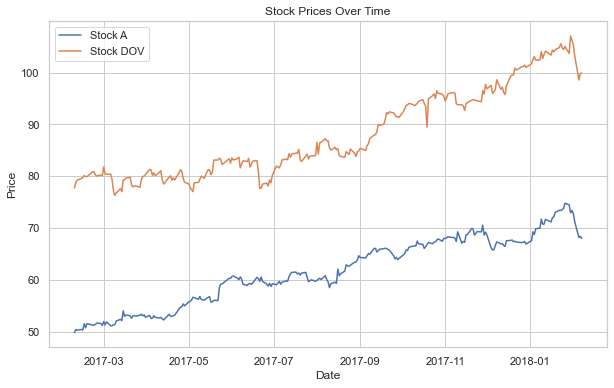

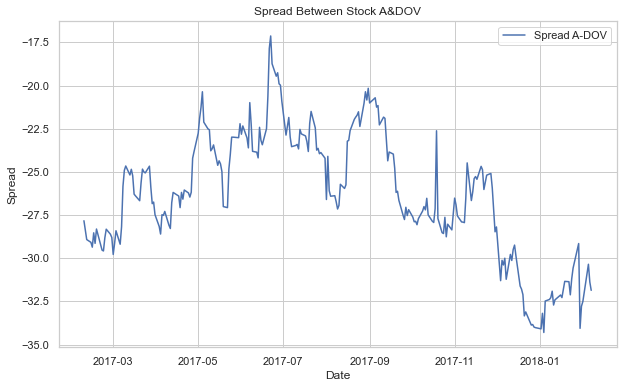

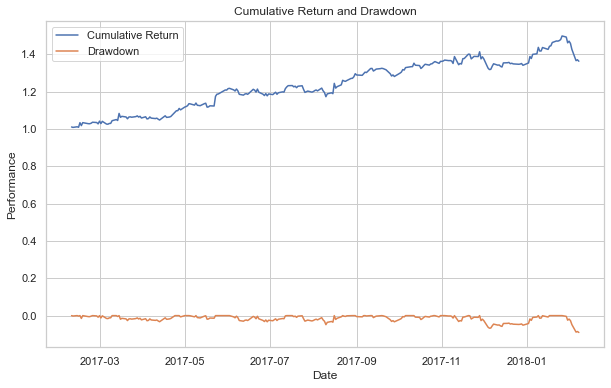

Maximum Drawdown: -0.0904
Annualized Return: 0.3631
Annualized Volatility: 0.1734
Sharpe Ratio: 0.1184636103


In [474]:
i = 'A'
j = 'DOV'
#backtest.head()
#backtest[[i,j]]
backtestor(backtest[[i,j]],i,j)

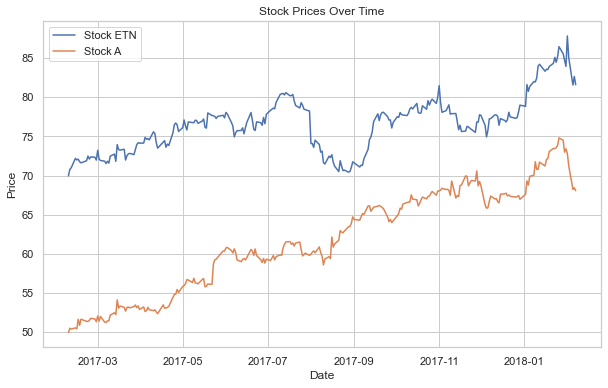

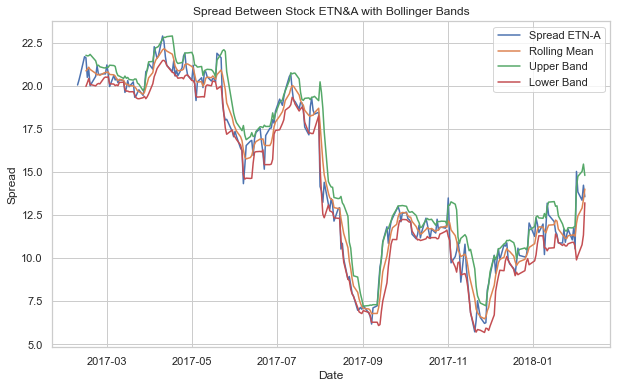

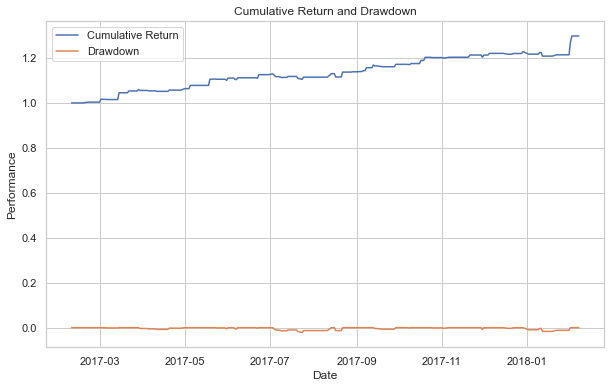

Maximum Drawdown: -0.0214
Annualized Return: 0.2981
Annualized Volatility: 0.0849
Sharpe Ratio: 0.1970548489


In [483]:
i = 'ETN'
j = 'A'
#backtest.head()
#backtest[[i,j]]
backtestor_Bollinger(backtest[[i,j]],i,j)